In [1]:
import numpy as np

from optyx import optyx, zx, zw, lo
from optyx.channel import *

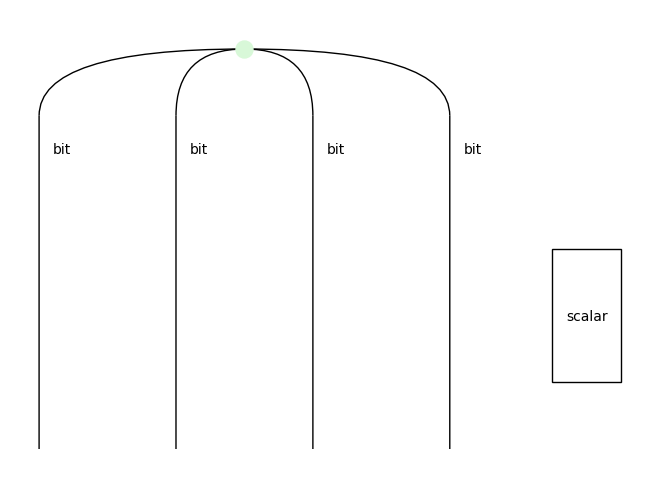

In [29]:
logical_ket_00 = zx.Z(0, 4) @ optyx.Scalar(1/np.sqrt(2))
Logical_ket_00 = Channel('|00>', logical_ket_00)

logical_bra_00 = zx.Z(4, 0) @ optyx.Scalar(1/np.sqrt(2))
Logical_bra_00 = Channel('<00|', logical_bra_00)

logical_ket_00.draw()

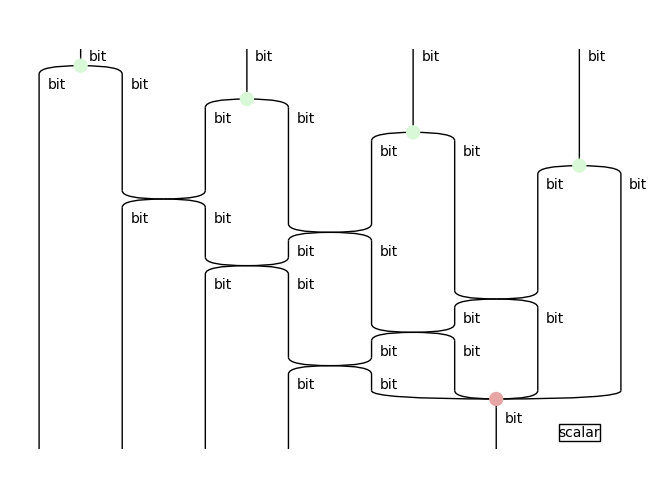

In [3]:
x_detector = (
        (zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2))
        >> optyx.Diagram.permutation([0, 2, 4, 6, 1, 3, 5, 7], optyx.bit ** 8)
        >> optyx.Id(optyx.bit ** 4) @ zx.X(4, 1)
        @ zx.Scalar(np.sqrt(2)**3)
)
X_detector = Channel('X Error Detector', x_detector, dom=qubit ** 4, cod=qubit**4 @ bit)

x_detector.draw()

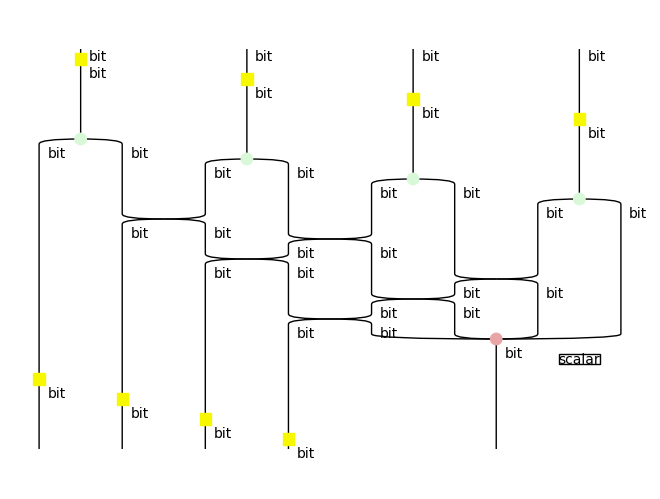

In [14]:
z_detector = diag_pow(zx.H, 4) >> x_detector >> diag_pow(zx.H, 4) @ zx.Id(1)
Z_detector = Channel('Z Error Detector', z_detector, dom=qubit ** 4, cod=qubit**4 @ bit)

z_detector.draw()

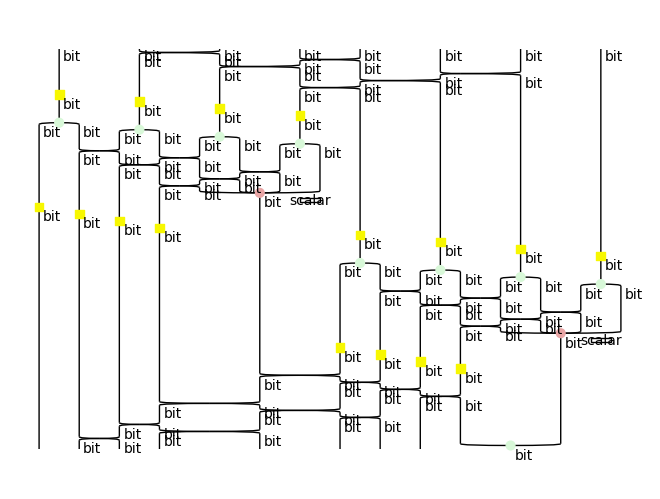

In [15]:
Z_detector.double().draw()

(3.749399456654641e-33+0j)


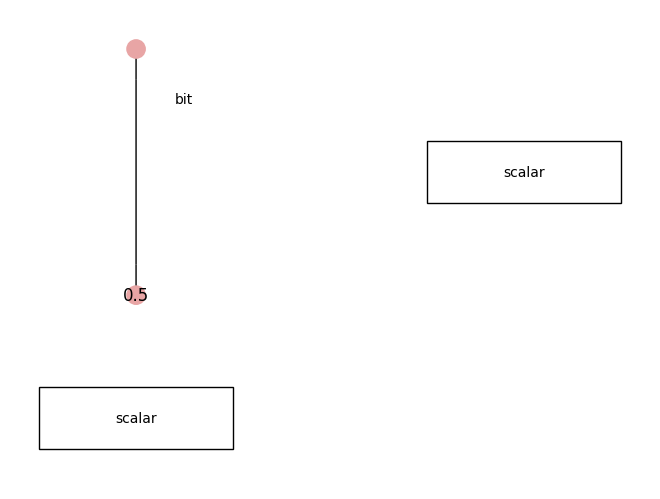

In [6]:
ket_0 = zx.X(0, 1) @ optyx.Scalar(1/np.sqrt(2))
Ket_0 = Channel('|0>', ket_0)

ket_1 = zx.X(0, 1, phase=0.5) @ optyx.Scalar(1/np.sqrt(2))
Ket_1 = Channel('|1>', ket_1)

ket_plus = zx.Z(0, 1) @ optyx.Scalar(1/np.sqrt(2))
Ket_plus = Channel('|+>', ket_plus)

ket_minus = zx.Z(0, 1, phase=0.5) @ optyx.Scalar(1/np.sqrt(2))
Ket_minus = Channel('|->', ket_minus)

bra_0 = zx.X(1, 0) @ optyx.Scalar(1/np.sqrt(2))
Bra_0 = Channel('<0|', bra_0)

bra_1 = zx.X(1, 0, phase=0.5) @ optyx.Scalar(1/np.sqrt(2))
Bra_1 = Channel('<1|', bra_1)

bra_plus = zx.Z(1, 0) @ optyx.Scalar(1/np.sqrt(2))
Bra_plus = Channel('<+|', bra_plus)

bra_minus = zx.Z(1, 0, phase=0.5) @ optyx.Scalar(1/np.sqrt(2))
Bra_minus = Channel('<-|', bra_minus)

print((Ket_0 >> Bra_1).double().to_tensor().eval().array)
(ket_0 >> bra_1).draw()

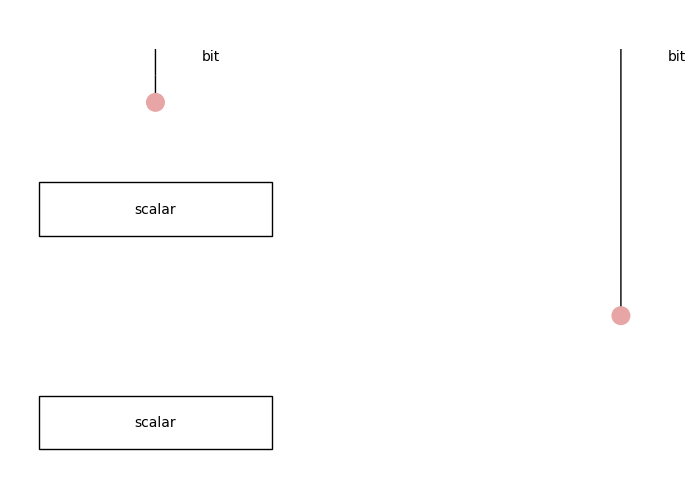

In [16]:
def diag_pow(diag, n):
    if n == 1:
        return diag
    return diag @ diag_pow(diag, n - 1)

diag_pow(bra_0, 2).draw()

0.24999999999999906


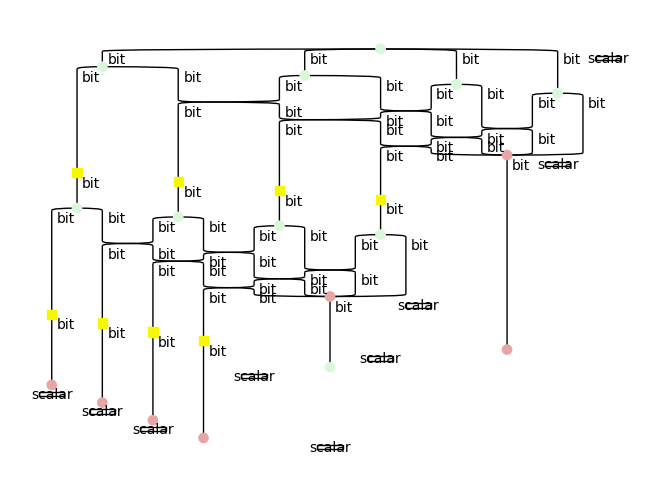

In [17]:
perfect_circuit = logical_ket_00 >> x_detector >> z_detector @ bra_0 >> optyx.Id(optyx.bit ** 4) @ bra_plus >>  diag_pow(bra_0, 4)

print(np.abs(perfect_circuit.to_tensor().eval().array) ** 2)
perfect_circuit.draw()

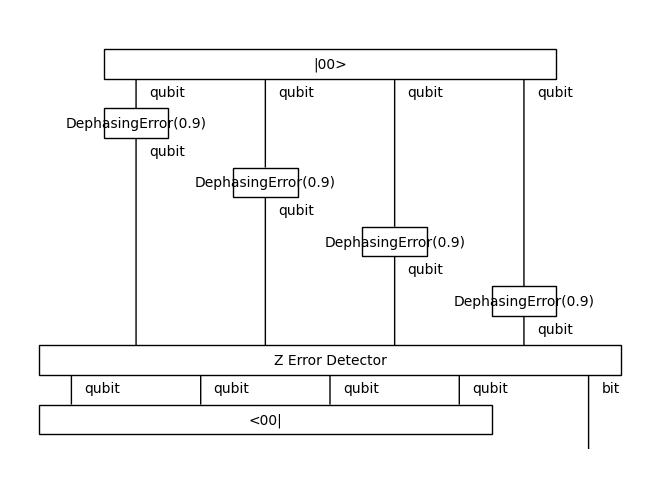

In [36]:
diagram = Logical_ket_00 >> diag_pow(DephasingError(0.95), 4) >> Z_detector >> Logical_bra_00 @ Circuit.id(bit)

diagram.draw()

In [35]:
diagram.double().to_tensor().eval().array

array([ 1.00000000e+00-1.22738556e-34j, -1.30890165e-34+0.00000000e+00j])

[0.9+0.j 0.1+0.j]


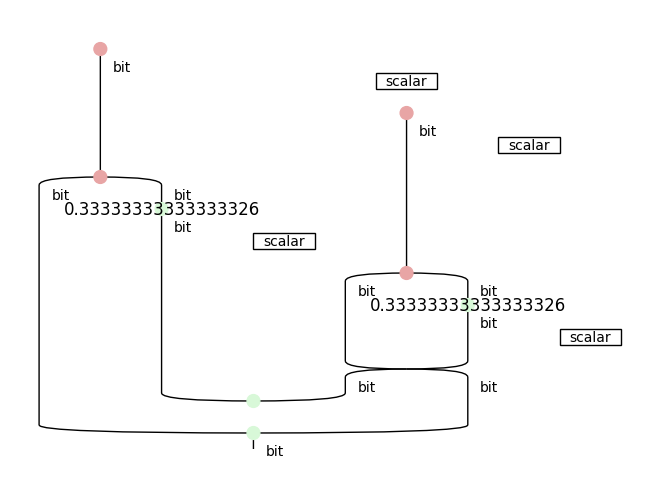

In [79]:
prob = 0.9
x_error = zx.X(1, 2) >> zx.Id(1) @ zx.ZBox(1, 1, np.sqrt((1-prob)/prob)) @ zx.Scalar(np.sqrt(prob * 2))
dephasing = Channel(name='X error', kraus=x_error, dom=qubit, cod=qubit, env=optyx.bit)

diag = Ket_0 >> dephasing >> Measure(qubit)
print(diag.double().to_tensor().eval().array)
diag.double().draw()

In [71]:
dephasing.double()

optyx.optyx.Diagram(inside=(rigid.Layer(optyx.optyx.Ty(), optyx.optyx.Spider(1, 2, optyx.optyx.Bit(optyx.optyx.Ob('bit'))), optyx.optyx.Ty(optyx.optyx.Ob('bit'))), rigid.Layer(optyx.optyx.Ty(optyx.optyx.Ob('bit')), optyx.zx.ZBox(1, 1, 0.33333333333333326), optyx.optyx.Ty(optyx.optyx.Ob('bit'))), rigid.Layer(optyx.optyx.Ty(optyx.optyx.Ob('bit'), optyx.optyx.Ob('bit')), optyx.optyx.Scalar('scalar', optyx.optyx.Mode(), optyx.optyx.Mode(), data=(1.3416407864998738+0j)), optyx.optyx.Ty(optyx.optyx.Ob('bit'))), rigid.Layer(optyx.optyx.Ty(optyx.optyx.Ob('bit'), optyx.optyx.Ob('bit')), optyx.optyx.Spider(1, 2, optyx.optyx.Bit(optyx.optyx.Ob('bit'))), optyx.optyx.Ty()), rigid.Layer(optyx.optyx.Ty(optyx.optyx.Ob('bit'), optyx.optyx.Ob('bit'), optyx.optyx.Ob('bit')), optyx.zx.ZBox(1, 1, 0.33333333333333326), optyx.optyx.Ty()), rigid.Layer(optyx.optyx.Ty(optyx.optyx.Ob('bit'), optyx.optyx.Ob('bit'), optyx.optyx.Ob('bit'), optyx.optyx.Ob('bit')), optyx.optyx.Scalar('scalar', optyx.optyx.Mode(), opt

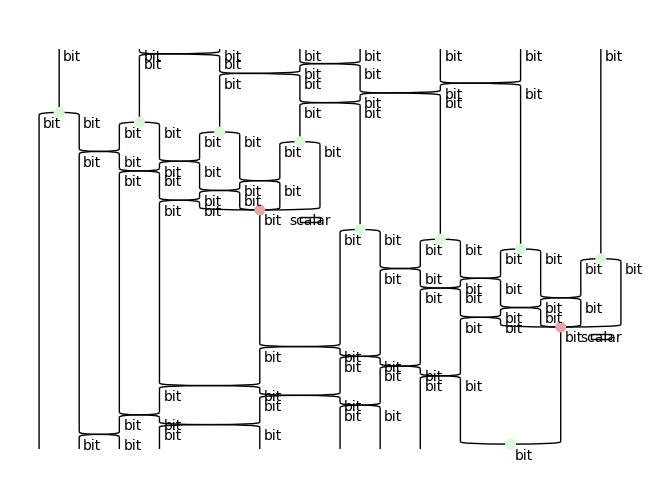

In [107]:
Z_detector.double().draw()